# Actividad: Aprendizaje no supervisado

**Instrucciones:**

1. Agrega la información personal del equipo en el espacio correspondiente.

2. Todas las librerías que vas a necesitar ya se encuentran definidas, sigue las instrucciones de lo que se te pide.

3. Ve ejecutando celda por celda.

4. Al finalizar, descarga el notebook obtenido (.ipynb) y súbelo en el espacio correspondiente (**sólo uno por equipo**). Se recomienda ejecutar el comando `Entorno de ejecución > Reiniciar y ejecutar todo` para verificar que no haya errores.

**Información del Equipo:**

* *Carlos Cabrera Castrejon*
* *Ricardo Flores Peregrina*

In [3]:
#@title Librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.compose import make_column_transformer # Pre-procesamiento
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Pre-procesamiento
from sklearn.decomposition import PCA # Reducción dimensionalidad

from sklearn.model_selection import train_test_split # Dividir datos

from sklearn.neighbors import KNeighborsClassifier # <----- CLASIFICACION
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans # <----- CLUSTERING

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay # <----- EVALUACION

# Resultados reproducibles
np.random.seed(42)

# Ignorar warnings
warnings.filterwarnings('ignore')

## Predicciones en Spotify (PCA)

El conjunto de datos se recolectó utilizando el API de Spotify. La idea es predecir si una canción te va a gustar o no, basándose en tus preferencias musicales.

Cada canción cuenta con diversos datos como el nombre, el artista, la duración, y atributos relacionados con la música como la energía, la instrumentalidad, el tempo, que tan bailable es... etc.

In [4]:
#@title Ejecuta el siguiente código para visualizar el conjunto de datos

dataset = pd.read_csv('https://raw.githubusercontent.com/miryamelizabeth/datasets/main/spotify_dataset.csv')
dataset.drop(['id', 'song_name', 'type1', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)
dataset.sample(n=5, random_state=42)

,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_min,time_signature,class
582,Imagine Dragons,0.636,0.718,1,-4.833,0,0.0313,0.00483,0.000007,0.2920,0.437,143.929,3.631189,4,yes
901,Avril Lavigne,0.582,0.758,5,-5.951,1,0.0464,0.06150,0.000008,0.3090,0.413,77.982,4.075198,4,yes
907,The Corrs,0.607,0.820,11,-7.754,1,0.0597,0.05410,0.000068,0.2690,0.768,126.988,3.458519,4,yes
1754,Los Huracanes del Norte,0.546,0.309,3,-17.473,1,0.0892,0.04070,0.000000,0.0651,0.624,157.012,3.361584,3,no
1464,Tropicalísimo Apache,0.476,0.412,2,-15.205,1,0.0532,0.27200,0.000794,0.1060,0.965,204.429,2.918275,4,no


**1. Utiliza un `MinMaxScaler` para transformar los datos**

In [5]:
# Separamos predictores (X)
X = dataset.drop(['artist', 'class'], axis=1)

# Columnas numéricas
num_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_min', 'time_signature']

# Paso 1. Crear el transformer
transformer = make_column_transformer( (StandardScaler(), num_cols) )
transformer.fit(X) 

# Transformamos los datos
X = transformer.transform(X)

**2. PCA debe capturar el 95% de la varianza de los datos**

In [6]:
# Paso 1. PCA
pca = PCA(n_components=0.95)
pca.fit(X)

# Transformar datos con las nuevas dimensiones
X = pca.transform(X)

**3. Completa el siguiente código para obtener lo siguiente en c/variable:**
- ``variance``: la variabilidad explicada por componente principal.
- ``sum_variance``: la variabilidad explicada acumulada.
- ``num_componentes``: el número de componentes calculado por PCA.

In [7]:
variace = pca.explained_variance_ratio_
sum_variance = sum(variace)
num_components = pca.n_components_

print(f'Variabilidad explicada por componente principal: {variace}\n')
print(f'Variabilidad explicada acumulada: {sum_variance:.3f}\n')
print(f'Número de componentes obtenidos: {num_components}')

Variabilidad explicada por componente principal: [0.25119966 0.11245931 0.09525787 0.08339492 0.0790674  0.06973141
 0.06825085 0.06466791 0.05743381 0.05241122 0.02983178]

Variabilidad explicada acumulada: 0.964

Número de componentes obtenidos: 11


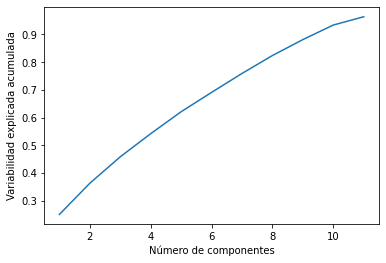

In [8]:
#@title Ejecuta el siguiente código para mostrar la gráfica del acumulado de variabilidad explicada en las nuevas dimensiones
plt.plot(range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Variabilidad explicada acumulada')
plt.show()

### Preguntas

1. ¿Aproximadamente cuanta información (porcentaje de varianza %) retienen los dos primeros componentes?
2. ¿Cuántos componentes se necesitan para capturar el 95% de información del conjunto de datos?
3. De acuerdo con la gráfica que muestra el acumulado de variabilidad, ¿cuántos componentes se necesitarían para capturar aprox 85% de información?

Inserta aquí tus respuestas:

1. 36.37%
2. 11 componentes
3. 9 componentes

## Segmentación de mercados (Clustering)

Imagina que eres propietario de un supermercado y, a través de las tarjetas de socio, dispones de algunos datos básicos sobre tus clientes, como la edad, el sexo, los ingresos anuales y la puntuación de gasto.
La puntuación de gasto es algo que se asigna al cliente en función de los parámetros definidos, como el comportamiento del cliente y los datos de compra.

**Planteamiento del problema**
Quieres entender qué tipos de clientes tienes (segmentarlos) para que el equipo de marketing pueda planificar estrategia de ventas.

In [9]:
dataset = pd.read_csv('https://raw.githubusercontent.com/miryamelizabeth/datasets/main/Datasets%20ML/dataset_customers_segmentation.csv')
dataset.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


**1. Utiliza la instrucción de pandas para describir los datos con las principales estadísticas**




In [10]:
dataset.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


**2. Realiza un `histplot` de la edad de los clientes. Agrega dentro de la función el parámetro `binwidth=11` (esto separa en barras de 10 años aprox, es decir de 18 a 28 años, etc.)**

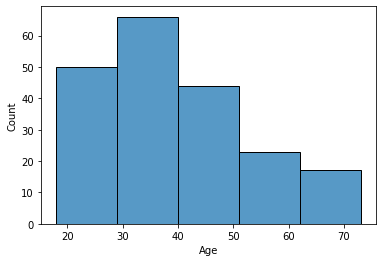

In [11]:
sns.histplot(x='Age', binwidth=11, data=dataset)
plt.show()

**3. Realiza un `histplot` del ingreso anual de los clientes. Agrega dentro de la función el parámetro `bins=6` (esto separa en 6 barras iguales los datos).**

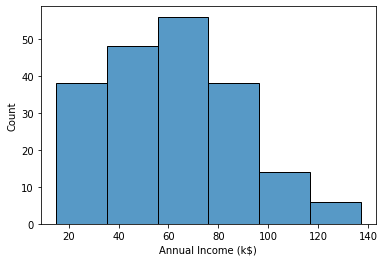

In [12]:
sns.histplot(x='Annual Income (k$)', bins=6, data=dataset)
plt.show()

**4. Realiza una gráfica de contar visualizar la distribución del género de los clientes de la tienda.**

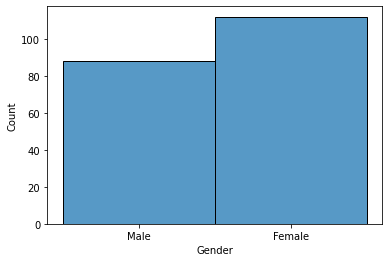

In [13]:
sns.histplot(x='Gender', data=dataset)
plt.show()

**5. Realiza un scatterplot del los gastos vs ingreso anual.**

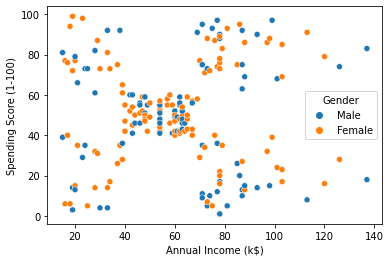

In [14]:
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',hue='Gender', data=dataset)
plt.show()

**6. Utiliza ``StandardScaler`` para transformar los datos numéricos**

In [15]:
# Separamos los predictores
X = dataset[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# TODAS las columnas numéricas se guardan en una lista
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Paso 1. Reescalamiento de datos
transformer = make_column_transformer( (StandardScaler(), num_cols) )
transformer.fit(X)

# Transforma los datos
X = transformer.transform(X)

**7. Agrega la instrucción adecuada para obtener la inercia del modelo**

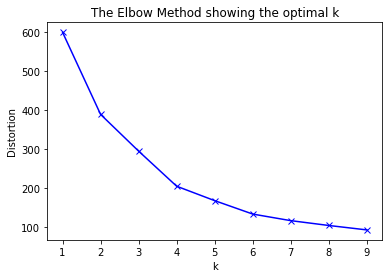

In [16]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_) # Obtener inercia <------

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**8. Completa lo siguiente:**
- Paso 1. Utilizando la gráfica anterior determina el número de clusters y agregalo al modelo `KMeans()`.
- Paso 2. Obten los centros de los clusters.
- Paso 3. Obten las etiquetas de c/instancia (es decir, el cluster al que pertenecen).

In [17]:
# Paso 1. Kmeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

# Paso 2. Centros del agrupamiento
centers = kmeans.cluster_centers_
print(f'Centros:\n{centers}\n')

# Paso 3. Etiquetas de c/instancia
labels = kmeans.labels_
print(f'Labels: {labels[:20]}...')

Centros:
[[ 0.70892251 -0.00247545 -0.69939115]
 [-0.75277339  0.00262858  0.74265245]]

Labels: [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]...


**9. Agrega las etiquetas a la nueva columna ``cluster``**

In [18]:
dataset['cluster'] = labels
dataset.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,1
2,Female,20,16,6,0
3,Female,23,16,77,1
4,Female,31,17,40,1


In [19]:
#@title Ejecuta el siguiente código para visualizar la distribución de datos en cada cluster...
resultado = dataset['cluster'].value_counts(normalize='True').round(3) * 100
resultado.to_frame(name='elementos(%)').reset_index().rename(columns={'index': 'cluster'})

,cluster,elementos(%)
0,0,51.5
1,1,48.5


**10. Crea un boxplot para visualizar la edad con respecto a los clusters.**

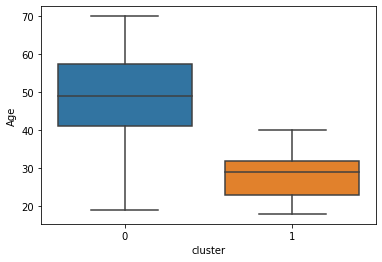

In [20]:
sns.boxplot(x='cluster', y='Age', data=dataset)
plt.show()

**11. Agrega la división (hue) utilizando ``cluster`` en el siguiente scatterplot**

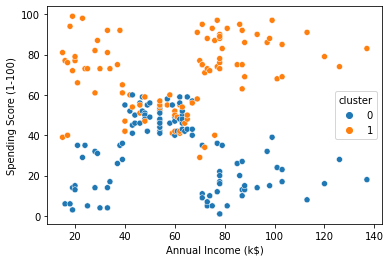

In [21]:
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='cluster', data=dataset)
plt.show()

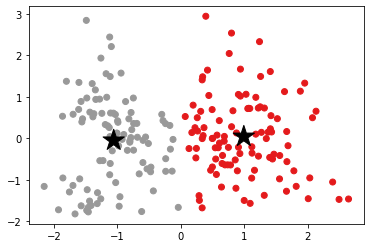

In [22]:
#@title Ejecuta el siguiente código para visualizar con PCA los clusters obtenidos
# Creamos objeto PCA, enviamos el número de componentes a obtener (número de atributos/dimensiones)
pca = PCA(n_components=2)
pca.fit(X)

# Convertimos nuestros datos y los centros a las nuevas dimensiones de PCA
X_pca = pca.transform(X)
pca_centers = pca.transform(centers)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels
pca_df.head()

color_list = kmeans.n_clusters * ['black']

plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap=plt.cm.Set1)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], c=color_list, marker='*', s=500)
plt.show()

In [23]:
dataset['Age'].min

<bound method NDFrame._add_numeric_operations.<locals>.min of 0      19
1      21
2      20
3      23
4      31
       ..
195    35
196    45
197    32
198    32
199    30
Name: Age, Length: 200, dtype: int64>

### Preguntas

1. ¿Entre que rangos de edad se encuentran la mayoría de los clientes? 
2. ¿Qué edad tienen los clientes más jóvenes?
3. ¿Cuáles son los ingresos anuales de la mayoría de los clientes?
4. ¿Cuál es el máximo de ingresos que tienen los clientes?
5. Hay más mujeres que hombres de clientes en la tienda. ¿Verdadero o Falso?
6. De acuerdo con la gráfica de Elbow Method, ¿cuántos clusters hay?
7. ¿Qué tan equilibrada está la distribución de datos en cada cluster?
8. ¿Cuál es la mediana de edad para cada cluster?
9. De acuerdo con la gráfica del punto 11, el spending score del cluster 1 se encuentra arriba (aprox) de cuál valor.

1. **Entre 30 - 40**
2. **18 años aproximado**
3. **Entre 57k - 77k aproximadamente**
4. **135k aproximadamente**
5. **Verdadero**
6. **9**
7. **Aproximadamente cada cluster tiene la mitad de los datos (51.5% y 48.5%)**
8. **El cluster 0 tiene una mediana de aprox. 48 años y el cluster 1 aprox. 30 años**
9. **En mi caso, parece ser que el spending score sale arriba de 25 puntos**


---


📝 **Referencias**

*Dataset obtenido de Kaggle repository:* [Customer segmentation](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).